In [1]:
import syft as sy
import os
from syft import ActionObject
from collections import defaultdict

Start this using

```
tox -e dev.k8s.start
tox -e dev.k8s.deploy
```

In [4]:
client = sy.login(url="http://localhost:8080", email="info@openmined.org", password="changethis")

Logged into <mynode: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

<DomainClient: mynode>
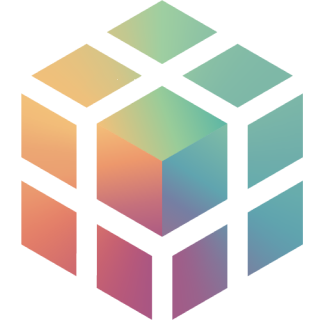

In [5]:
client

# Mount storage container with Helm azure container

# Start workers

In [6]:
# # 8 high performance on m2
# worker_count = os.cpu_count() - 4
# worker_count

In [7]:
# client.worker.start_workers(n=worker_count)
client.worker.start_workers(n=2)

SyftSuccess: 2 workers added

In [8]:
client.worker.list()

[syft.service.worker.worker_service.ContainerWorker,
 syft.service.worker.worker_service.ContainerWorker]

# Create Dataset

In [9]:
# split.py
# # stdlib
# import os
# import sys


# def split_file(file_path, num_chunks):
#     with open(file_path, 'r', encoding='utf-8') as file:
#         total_lines = sum(1 for line in file)

#     lines_per_chunk = total_lines // num_chunks

#     with open(file_path, 'r', encoding='utf-8') as file:
#         for chunk in range(num_chunks):
#             print(f"Creating chunk {chunk}")
#             chunk_file_name = f"{os.path.splitext(file_path)[0]}-chunk-{str(chunk).zfill(len(str(num_chunks)))}.jsonl"
#             with open(chunk_file_name, 'w', encoding='utf-8') as chunk_file:
#                 for _ in range(lines_per_chunk):
#                     line = file.readline()
#                     if not line:
#                         break
#                     chunk_file.write(line)

#                 # Handle any remaining lines for the last chunk
#                 if chunk == num_chunks - 1:
#                     for line in file:
#                         chunk_file.write(line)

# if __name__ == "__main__":
#     if len(sys.argv) != 2:
#         print("Usage: python script.py <filename>")
#         sys.exit(1)

#     file_path = sys.argv[1]
#     num_chunks = os.cpu_count() or 1  # Default to 1 if cpu_count is None
#     split_file(file_path, num_chunks)


In [10]:
# download filtered_scenario_data_new.jsonl from azure
# download train-00.jsonl from azure
# run split.py train-00.jsonl
# WARNING: bug where files around 2GB are causing issues with upload so try ~200mb

In [11]:
data_dir = "/Users/madhavajay/dev/data/"

In [12]:
scenario_path = f"{data_dir}filtered_scenario_data_new.jsonl"

In [13]:
# train-00-chunk-00.jsonl

In [14]:
scenario_file = sy.ActionObject.from_path(path=scenario_path).send(client).syft_action_data

("WARNING: No Type for <class 'syft.service.action.action_data_empty.ActionFileData'>, returning <class 'syft.service.action.action_object.AnyActionObject'>",)
('>> ', 'syft_history_hash', ', defined_on_self = ', True)
('>> ', 'syft_node_location', ', defined_on_self = ', True)
('>> ', 'syft_client_verify_key', ', defined_on_self = ', True)
('>> ', 'syft_blob_storage_entry_id', ', defined_on_self = ', True)
('>> ', 'syft_action_data_type', ', defined_on_self = ', True)
('>> ', 'syft_action_data_repr_', ', defined_on_self = ', True)
('>> ', 'syft_action_data_str_', ', defined_on_self = ', True)
('>> ', 'syft_has_bool_attr', ', defined_on_self = ', True)
('>> ', 'syft_action_data_cache', ', defined_on_self = ', True)
('>> ', 'syft_action_data_cache', ', defined_on_self = ', True)
('>> ', 'syft_history_hash', ', defined_on_self = ', True)
('>> ', 'syft_created_at', ', defined_on_self = ', True)
('>> ', 'syft_action_data_cache', ', defined_on_self = ', True)
('>> ', 'syft_action_data_type'

In [24]:
split_files = []
import os
count = 0
for file in os.listdir(data_dir):
    count += 1
    if count < 2:
        continue

    print(file)
    if file.startswith("train-00-chunk") and file.endswith(".jsonl"):
        name = file.split(".")[0]
        path = os.path.join(data_dir, file)
        split_files.append((name, path))

train-00-chunk-013.jsonl
train-00-chunk-037.jsonl
train-00-chunk-008.jsonl
train-00-chunk-035.jsonl
train-00-chunk-054.jsonl
train-00-chunk-011.jsonl
train-00-chunk-050.jsonl
train-00-chunk-015.jsonl
.DS_Store
train-00-chunk-028.jsonl
train-00-chunk-049.jsonl
train-00-chunk-031.jsonl
filtered_scenario_data_new.jsonl
train-00-chunk-033.jsonl
train-00-chunk-052.jsonl
train-00-chunk-017.jsonl
train-00-chunk-034.jsonl
train-00-chunk-009.jsonl
train-00-chunk-010.jsonl
train-00-chunk-055.jsonl
train-00-chunk-012.jsonl
train-00-chunk-057.jsonl
train-00-chunk-036.jsonl
train-00.jsonl
train-00-chunk-032.jsonl
train-00-chunk-016.jsonl
train-00-chunk-053.jsonl
train-00-chunk-029.jsonl
train-00-chunk-014.jsonl
train-00-chunk-051.jsonl
train-00-chunk-030.jsonl
train-00-chunk-048.jsonl
train-00-chunk-044.jsonl
train-00-chunk-001.jsonl
train-00-chunk-018.jsonl
train-00-chunk-060.jsonl
train-00-chunk-025.jsonl
train-00-chunk-027.jsonl
train-00-chunk-046.jsonl
train-00-chunk-003.jsonl
split.py
train-00

In [25]:
split_files_small = split_files[2:4]
split_files_small

[('train-00-chunk-008', '/Users/madhavajay/dev/data/train-00-chunk-008.jsonl'),
 ('train-00-chunk-035', '/Users/madhavajay/dev/data/train-00-chunk-035.jsonl')]

In [26]:
train_files = []
for file in split_files_small:
    path = file[1]
    data = sy.ActionObject.from_path(path)
    train_file = data.send(client).syft_action_data
    train_files.append(train_file)
    print("Added ", file)

("WARNING: No Type for <class 'syft.service.action.action_data_empty.ActionFileData'>, returning <class 'syft.service.action.action_object.AnyActionObject'>",)
('>> ', 'syft_history_hash', ', defined_on_self = ', True)
('>> ', 'syft_node_location', ', defined_on_self = ', True)
('>> ', 'syft_client_verify_key', ', defined_on_self = ', True)
('>> ', 'syft_blob_storage_entry_id', ', defined_on_self = ', True)
('>> ', 'syft_action_data_type', ', defined_on_self = ', True)
('>> ', 'syft_action_data_repr_', ', defined_on_self = ', True)
('>> ', 'syft_action_data_str_', ', defined_on_self = ', True)
('>> ', 'syft_has_bool_attr', ', defined_on_self = ', True)
('>> ', 'syft_action_data_cache', ', defined_on_self = ', True)
('>> ', 'syft_action_data_cache', ', defined_on_self = ', True)
('>> ', 'syft_history_hash', ', defined_on_self = ', True)
('>> ', 'syft_created_at', ', defined_on_self = ', True)
('>> ', 'syft_action_data_cache', ', defined_on_self = ', True)
('>> ', 'syft_action_data_type'

In [27]:
print("done")

done


In [28]:
helm_dataset = sy.Dataset(
    name=f"Helm Dataset",
    asset_list=[
        sy.Asset(
            name="helm train data",
            data=ActionObject.from_obj(train_files),
            mock=sy.ActionObject.empty()
        ),
        sy.Asset(
            name="helm test data",
            data=ActionObject.from_obj([scenario_file]),
            mock=sy.ActionObject.empty()
        )
    ]
)

("WARNING: No Type for <class 'list'>, returning <class 'syft.service.action.action_object.AnyActionObject'>",)
('>> ', 'syft_history_hash', ', defined_on_self = ', True)
('>> ', 'syft_resolved', ', defined_on_self = ', True)
("WARNING: No Type for <class 'syft.service.action.action_data_empty.ActionDataEmpty'>, returning <class 'syft.service.action.action_object.AnyActionObject'>",)
('>> ', 'syft_history_hash', ', defined_on_self = ', True)
('>> ', 'syft_resolved', ', defined_on_self = ', True)
("WARNING: No Type for <class 'list'>, returning <class 'syft.service.action.action_object.AnyActionObject'>",)
('>> ', 'syft_history_hash', ', defined_on_self = ', True)
('>> ', 'syft_resolved', ', defined_on_self = ', True)
("WARNING: No Type for <class 'syft.service.action.action_data_empty.ActionDataEmpty'>, returning <class 'syft.service.action.action_object.AnyActionObject'>",)
('>> ', 'syft_history_hash', ', defined_on_self = ', True)
('>> ', 'syft_resolved', ', defined_on_self = ', True

In [29]:
client.upload_dataset(helm_dataset)

100%|███████████████████████████████████████| 2/2 [00:00<00:00, 11.06it/s]


Uploading: helm train data
('>> ', 'syft_node_location', ', defined_on_self = ', True)
('>> ', 'syft_client_verify_key', ', defined_on_self = ', True)
('>> ', 'syft_blob_storage_entry_id', ', defined_on_self = ', True)
('>> ', 'syft_action_data_type', ', defined_on_self = ', True)
('>> ', 'syft_action_data_repr_', ', defined_on_self = ', True)
('>> ', 'syft_action_data_str_', ', defined_on_self = ', True)
('>> ', 'syft_has_bool_attr', ', defined_on_self = ', True)
('>> ', 'syft_action_data_cache', ', defined_on_self = ', True)
('>> ', 'syft_action_data_cache', ', defined_on_self = ', True)
('>> ', 'syft_history_hash', ', defined_on_self = ', True)
Uploading: helm test data
('>> ', 'syft_node_location', ', defined_on_self = ', True)
('>> ', 'syft_client_verify_key', ', defined_on_self = ', True)
('>> ', 'syft_blob_storage_entry_id', ', defined_on_self = ', True)
('>> ', 'syft_action_data_type', ', defined_on_self = ', True)
('>> ', 'syft_action_data_repr_', ', defined_on_self = ', True)

SyftSuccess: Dataset uploaded to 'mynode'. To see the datasets uploaded by a client on this node, use command `[your_client].datasets`

In [30]:
helm_ds = client.datasets[helm_dataset.name]
helm_train_files = helm_ds.assets["helm train data"]
helm_test_files = helm_ds.assets["helm test data"]

# Syft functions

In [31]:
@sy.syft_function()
def compute_document_data_overlap(domain, scenario_file, input_files, n):
    print("starting overlap computation")

    from nltk import ngrams
    from collections import defaultdict
    from string import punctuation
    import re, json
    import time

    r = re.compile(r"[\s{}]+".format(re.escape(punctuation)))
    
    def create_ngram_index(light_scenarios, n_values, stats_key_counts):
        ngram_index = {n:{}  for n in n_values}
        for i, scenario in enumerate(light_scenarios):
            if i%20 == 0:
                print(f"n_gram indexing progress: {(i/len(light_scenarios))*100:.2f}%")
            for n in n_values:
                stats_key = scenario['scenario_key'] + '_' + str(n)
                stats_key_counts[stats_key] = len(scenario['instances'])
                for instance in scenario['instances']:
                    id = instance['id']                    
                    input_tokens = r.split(instance['input'].lower())
                    for input_ngram in ngrams(input_tokens, n):
                        if input_ngram not in ngram_index[n]:
                            ngram_index[n][input_ngram] = set()
                        ngram_index[n][input_ngram].add(stats_key + '+' + id + '+' + 'input')

                    # compute reference ngrams
                    for reference in instance['references']:
                        reference_unigrams = r.split(reference.lower())
                        for reference_ngram in ngrams(reference_unigrams, n):
                            if reference_ngram not in ngram_index[n]:
                                ngram_index[n][reference_ngram] = set()
                            ngram_index[n][reference_ngram].add(stats_key + '+' + id + '+' + 'references')
        return ngram_index
    
    # SETUP
    print("preparing scenarios and creating indexes")
    start = time.time()
    light_scenarios = []
    for i, (bytes_read, light_scenario_json) in enumerate(scenario_file.iter_lines(progress=True)):
        if i % 20 == 0:
            print(f"scenario creation progress: {(bytes_read/scenario_file.file_size)*100:.2f}%")

        light_scenario_dict: dict = json.loads(light_scenario_json)

        light_scenario_key_dict: dict = light_scenario_dict["scenario_key"]
        scenario_spec = str(light_scenario_key_dict["scenario_spec"])

        light_scenario_key = scenario_spec + '_' + light_scenario_key_dict["split"]
        light_instances = [
            {
                'input': instance_dict['input'], 
                'references': instance_dict['references'], 
                'id': instance_dict["id"]
            }
            for instance_dict in light_scenario_dict["instances"]
        ]
        light_scenarios.append({'scenario_key': light_scenario_key, 'instances': light_instances})
    print(f"Finished creating scenarios ({time.time()-start}s)")
    
    print("Creating indexes")
    
    start = time.time()
    stats_key_counts = defaultdict(int)
    ngram_index = create_ngram_index(
        light_scenarios=light_scenarios, n_values=[n], stats_key_counts=stats_key_counts
    )
    print(f"Finished creating indexes ({time.time()-start}s)")
        
    
    r = re.compile(r"[\s{}]+".format(re.escape(punctuation)))
    stats_key_to_input_ids = defaultdict(set)
    stats_key_to_reference_ids = defaultdict(set)
    print("computing overlap")
    start = time.time()
    
    domain.init_progress(input_files[0].file_size)

    for input_file in input_files:
        for i, (bytes_read, line) in enumerate(input_file.iter_lines(progress=True)):
            if i%1000 == 0:
                print(f"computing overlap progress: {(bytes_read / input_file.file_size) * 100:.2f}%")
                domain.set_progress(bytes_read)
            if i==10000:
                break
            document = json.loads(line)["text"]
            document_tokens = r.split(document.lower())
            for n in ngram_index.keys():
                for document_ngram in ngrams(document_tokens, n):
                    if document_ngram in ngram_index[n]:
                        for entry_overlap_key in ngram_index[n][document_ngram]:
                            stats_key, id, part = entry_overlap_key.split("+")
                            if part == "input":
                                stats_key_to_input_ids[stats_key].add(id)
                            elif part == "references":
                                stats_key_to_reference_ids[stats_key].add(id)
    print(f"Finished computing overlap ({time.time()-start}s)")
    print("done")
    
    return stats_key_to_input_ids, stats_key_to_reference_ids, stats_key_counts

SyftSuccess: Syft function 'compute_document_data_overlap' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

In [32]:
client.code.submit(compute_document_data_overlap)

SyftSuccess: User Code Submitted

In [33]:
@sy.syft_function_single_use(input_files=helm_train_files, scenario_files=helm_test_files)
def main_function(domain, input_files, scenario_files):
    N = [5, 9, 13]
    jobs = []
    for n in N[:1]:
        for scenario_file in scenario_files:
            for train_file in input_files:
                batch_job = domain.launch_job(
                    compute_document_data_overlap,
                    scenario_file=scenario_file,
                    input_files=[train_file],
                    n=n
                )
                jobs.append(batch_job)

    return None


SyftSuccess: Syft function 'main_function' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

In [34]:
client.code.request_code_execution(main_function)

syft.service.request.request.Request

In [35]:
client.requests[-1].approve(approve_nested=True)

Request approved for domain mynode


SyftSuccess: Request e4fea2293fbc426a8b2719b4b387e9c8 changes applied

In [ ]:
assert False

In [36]:
job = client.code.main_function(input_files=helm_train_files,
                                scenario_files=helm_test_files,
                                blocking=False)

('>> ', 'syft_history_hash', ', defined_on_self = ', True)


# Inspect Jobs and get results

In [37]:
job

('>> ', 'syft_history_hash', ', defined_on_self = ', True)
('>> ', '__str__', ', defined_on_self = ', False)
('[__getattribute__] Handling method __str__ ',)
('__str__ func is:',)
('inspect.isdatadescriptor', False)
('inspect.isgetsetdescriptor', False)
('inspect.isfunction', False)
('inspect.isbuiltin', False)
('inspect.ismethod', True)
('inspect.ismethoddescriptor', False)
('Running method: ', '__str__')
('name', '__str__', 'has no signature')


```python
class Job:
    id: UID = f16fd57d05694e9e9f4c8c2e92d9db34
    status: created
    has_parent: False
    result: ActionDataEmpty <None>
    logs:

0 
    
```

In [38]:
job.subjobs

('>> ', 'syft_history_hash', ', defined_on_self = ', True)
('>> ', 'syft_history_hash', ', defined_on_self = ', True)


[syft.service.job.job_stash.Job, syft.service.job.job_stash.Job]

In [39]:
# job.wait().get()

In [40]:
job.subjobs[0].logs()

('>> ', 'syft_history_hash', ', defined_on_self = ', True)
('>> ', 'syft_history_hash', ', defined_on_self = ', True)




In [41]:
results = [j.wait().get() for j in job.subjobs]

('>> ', 'syft_history_hash', ', defined_on_self = ', True)
('>> ', 'syft_history_hash', ', defined_on_self = ', True)
('>> ', 'syft_history_hash', ', defined_on_self = ', True)
('>> ', 'syft_action_data_cache', ', defined_on_self = ', True)
('>> ', 'syft_action_data_type', ', defined_on_self = ', True)
('>> ', 'syft_history_hash', ', defined_on_self = ', True)
('>> ', 'syft_action_data_cache', ', defined_on_self = ', True)
('>> ', 'syft_action_data_type', ', defined_on_self = ', True)


In [42]:
#stats_key_to_input_ids, stats_key_to_reference_ids, stats_key_counts
results

[(defaultdict(set,
              {"{'class_name': 'helm.benchmark.scenarios.the_pile_scenario.ThePileScenario', 'args': {'subset': 'Github'}}_test_5": {'id1000',
                'id1001',
                'id1002',
                'id1003',
                'id1005',
                'id1010',
                'id1013',
                'id1015',
                'id1017',
                'id1023',
                'id1025',
                'id1027',
                'id103',
                'id1031',
                'id1032',
                'id1036',
                'id1038',
                'id1042',
                'id1045',
                'id1047',
                'id1050',
                'id1052',
                'id1054',
                'id1056',
                'id1061',
                'id1063',
                'id1069',
                'id107',
                'id1070',
                'id1073',
                'id1074',
                'id1078',
                'id1079',
                'id1083',
                'id1084',
                'id1088',
                'id1091',
                'id1096',
                'id1099',
                'id110',
                'id1101',
                'id1103',
                'id1105',
                'id1108',
                'id1114',
                'id1115',
                'id1122',
                'id1123',
                'id1124',
                'id1125',
                'id1126',
                'id1127',
                'id1128',
                'id1132',
                'id1135',
                'id1136',
                'id114',
                'id1140',
                'id1142',
                'id1145',
                'id1146',
                'id1154',
                'id1158',
                'id1161',
                'id1168',
                'id1169',
                'id117',
                'id1170',
                'id1175',
                'id118',
                'id1180',
                'id1182',
                'id1183',
                'id1185',
                'id1186',
                'id1187',
                'id119',
                'id1190',
                'id1191',
                'id1193',
                'id1196',
                'id1197',
                'id1199',
                'id1200',
                'id1203',
                'id1210',
                'id1212',
                'id1213',
                'id1214',
                'id1217',
                'id1218',
                'id122',
                'id1220',
                'id1222',
                'id1223',
                'id1224',
                'id1226',
                'id1227',
                'id1228',
                'id1234',
                'id1236',
                'id1239',
                'id124',
                'id1244',
                'id1245',
                'id1246',
                'id1253',
                'id1255',
                'id1260',
                'id1261',
                'id1262',
                'id1265',
                'id1269',
                'id1270',
                'id1274',
                'id1275',
                'id1277',
                'id1281',
                'id1285',
                'id1287',
                'id1292',
                'id1294',
                'id1295',
                'id1301',
                'id1305',
                'id1307',
                'id1310',
                'id1311',
                'id1315',
                'id1317',
                'id1318',
                'id1319',
                'id1320',
                'id1321',
                'id1326',
                'id1328',
                'id133',
                'id1330',
                'id1333',
                'id1334',
                'id1336',
                'id1337',
                'id1340',
                'id1341',
                'id1342',
                'id1343',
                'id1344',
                'id1349',
                'id135',
 

In [ ]:
# results[0]

# Aggregate

In [ ]:
stats_key_to_input_ids, stats_key_to_reference_ids, stats_key_counts = zip(*results)

total_input_ids = defaultdict(set)
total_reference_ids = defaultdict(set)
total_stats_key_counts = defaultdict(int)

for d in stats_key_counts:
    for key, val in d.items():
        total_stats_key_counts[key] += val


for d in stats_key_to_input_ids:
    for key in d:
        new_set = set()
        if key in total_input_ids:
            new_set = total_input_ids[key]
        new_set = new_set.union(d[key])
        total_input_ids[key] = new_set

for d in stats_key_to_reference_ids:
    for key in d:
        new_set = set()
        if key in total_reference_ids:
            new_set = total_reference_ids[key]
        new_set = total_reference_ids[key].union(d[key])
        total_reference_ids[key] = new_set

all_data_overlap_stats = []
for stats_key, count in total_stats_key_counts.items():
    data_overlap_stats = {
        'data_overlap_stats_key': None,
        'num_instances': count,
        'instance_ids_with_overlapping_input': sorted(total_input_ids[stats_key]),
        'instance_ids_with_overlapping_reference': sorted(total_reference_ids[stats_key]),
    }
    subject, split, n_str = stats_key.rsplit('_', 2)
    data_overlap_stats['data_overlap_stats_key'] = {
        'light_scenario_key': {'scenario_spec': subject, 'split': split},
        'overlap_protocol_spec': {'n': int(n_str)}
    }
    all_data_overlap_stats.append(data_overlap_stats)


In [ ]:
from pprint import pprint
pprint(all_data_overlap_stats)